# FINAL PROJECT - NUMERAI

In [2]:
# imports
from numerapi import NumerAPI
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from scipy import stats
from sklearn.model_selection import train_test_split

## DATASET

The unique thing about Numerai's dataset is that it is `obfuscated`, which means that the underlying stock ids, feature names, and target definitions are anonymized.

In [3]:
# Initialize NumerAPI - the official Python API client for Numerai
napi = NumerAPI()

# list the datasets and available versions
all_datasets = napi.list_datasets()
dataset_versions = list(set(d.split('/')[0] for d in all_datasets))
print("Available versions:\n", dataset_versions)

# Set data version to one of the latest datasets
DATA_VERSION = "v4.3"

# Print all files available for download for our version
current_version_files = [f for f in all_datasets if f.startswith(DATA_VERSION)]
print("availbable", DATA_VERSION, "files:\n", current_version_files)

Available versions:
 ['v4', 'v4.2', 'v4.3', 'v4.1']
availbable v4.3 files:
 ['v4.3/features.json', 'v4.3/live_benchmark_models.parquet', 'v4.3/live_example_preds.csv', 'v4.3/live_example_preds.parquet', 'v4.3/live_int8.parquet', 'v4.3/meta_model.parquet', 'v4.3/train_benchmark_models.parquet', 'v4.3/train_int8.parquet', 'v4.3/validation_benchmark_models.parquet', 'v4.3/validation_example_preds.csv', 'v4.3/validation_example_preds.parquet', 'v4.3/validation_int8.parquet']


### DOWNLOAD THE DATASET

In [4]:
# download the feature metadata file
napi.download_dataset(f"{DATA_VERSION}/features.json");

# read the metadata and display
feature_metadata = json.load(open(f"{DATA_VERSION}/features.json"))
for metadata in feature_metadata:
  print(metadata, len(feature_metadata[metadata]))

2024-05-26 10:54:53,821 INFO numerapi.utils: target file already exists
2024-05-26 10:54:53,822 INFO numerapi.utils: download complete


feature_stats 2376
feature_sets 17
targets 41


In [5]:
feature_sets = feature_metadata["feature_sets"]
for feature_set in feature_sets:
# for feature_set in ["small", "medium", "all"]:
  print(feature_set, len(feature_sets[feature_set]))

small 42
medium 705
all 2376
v2_equivalent_features 304
v3_equivalent_features 1000
fncv3_features 400
intelligence 35
charisma 290
strength 135
dexterity 51
constitution 335
wisdom 140
agility 145
serenity 95
sunshine 325
rain 666
midnight 244


In [6]:
# Define our feature set
feature_set = feature_sets["small"]

# Download the training data - this will take a few minutes
napi.download_dataset(f"{DATA_VERSION}/train_int8.parquet")

2024-05-26 10:54:59,072 INFO numerapi.utils: target file already exists
2024-05-26 10:54:59,073 INFO numerapi.utils: download complete


'v4.3/train_int8.parquet'

In [41]:
# Load only the "small" feature set to
# Use the "all" feature set to use all features
feature_set = feature_sets["small"]
train = pd.read_parquet(
    f"{DATA_VERSION}/train_int8.parquet",
    columns=["era", "target"] + feature_set
)

# Downsample to every 4th era to reduce memory usage and speedup model training (suggested for Colab free tier)
train = train[train["era"].isin(train["era"].unique()[::4])]

In [42]:
# Split data into input and target
X = train.drop(columns=['target'])
y = train['target']


In [43]:
unique_eras = train['era'].unique()
train_eras, test_eras = train_test_split(unique_eras, test_size=0.2, random_state=42)

# Rozdelenie dátového rámca na tréningové a testovacie sety podľa éry
X_train = train[train['era'].isin(train_eras)].drop(columns=['target'])
y_train = train[train['era'].isin(train_eras)]['target']

X_test = train[train['era'].isin(test_eras)].drop(columns=['target'])
y_test = train[train['era'].isin(test_eras)]['target']

# Kontrola rozdelenia
print(f"Train eras: {len(train_eras)}, Test eras: {len(test_eras)}")
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

Train eras: 115, Test eras: 29
X_train shape: (484256, 43), y_train shape: (484256,)
X_test shape: (121920, 43), y_test shape: (121920,)


In [15]:
# train test split
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Model

In [45]:
# Define the custom numerai_corr function
def numerai_corr(preds, target):
  # rank (keeping ties) then Gaussianize predictions to standardize prediction distributions
  ranked_preds = (preds.rank(method="average").values - 0.5) / preds.count()
  gauss_ranked_preds = stats.norm.ppf(ranked_preds)
  
  # make targets centered around 0
  centered_target = target - target.mean()
  
  # raise both preds and target to the power of 1.5 to accentuate the tails
  preds_p15 = np.sign(gauss_ranked_preds) * np.abs(gauss_ranked_preds) ** 1.5
  target_p15 = np.sign(centered_target) * np.abs(centered_target) ** 1.5
  
  # finally return the Pearson correlation
  return np.corrcoef(preds_p15, target_p15)[0, 1]

# https://docs.numer.ai/numerai-tournament/scoring/correlation-corr

### XGBoost

XGBoost is a machine learning model that builds a series of decision trees and ensembles them. Because it uses decision trees, it is able to learn non-linear structures in the data unlike the linear regression and tends to have strong performance on a variety of problems.

In [46]:
import xgboost as xgb
model_xgb = xgb.XGBRegressor(n_estimators=2000, learning_rate=0.01, enable_categorical=True, max_depth=5,
  colsample_bytree=0.1)
model_xgb.fit(X_train.drop(columns=['era']), y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.1, device=None, early_stopping_rounds=None,
             enable_categorical=True, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=2000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [47]:
X_test['prediction_xgb'] = model_xgb.predict(X_test.drop(columns=['era']))

In [48]:
X_test['target'] = y_test.values

In [49]:
per_era_corr_xgb = X_test.groupby("era").apply(lambda x: numerai_corr(x["prediction_xgb"].dropna(), x["target"].dropna()))

<Axes: title={'center': 'Validation CORR XGB'}, xlabel='era'>

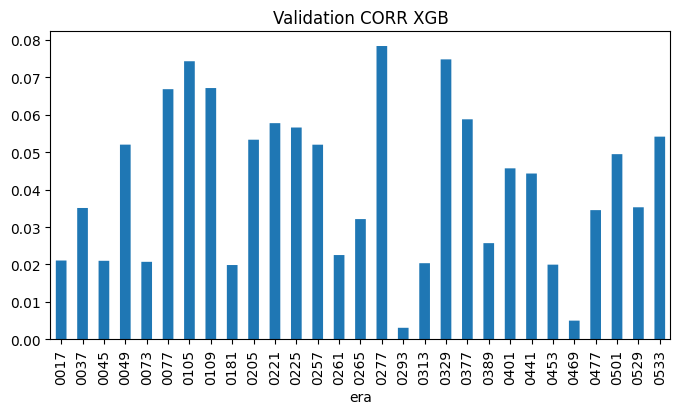

In [50]:
# Plot the per-era correlation
per_era_corr_xgb.plot(
    title="Validation CORR XGB",
    kind="bar",
    figsize=(8, 4),
    legend=False,
    snap=False
)

In [51]:
corr_mean_xgb = per_era_corr_xgb.mean()
corr_std_xgb = per_era_corr_xgb.std(ddof=0)
corr_sharpe_xgb = corr_mean_xgb / corr_std_xgb
corr_max_drawdown_xgb = (per_era_corr_xgb.cumsum().expanding(min_periods=1).max() - per_era_corr_xgb.cumsum()).max()

In [52]:
pd.DataFrame({
    "mean": corr_mean_xgb,
    "std": corr_std_xgb,
    "sharpe": corr_sharpe_xgb,
    "max_drawdown": corr_max_drawdown_xgb
}, index=["CORR XGB"]).T

,CORR XGB
mean,0.041439
std,0.020784
sharpe,1.993794
max_drawdown,0.000000


In [53]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer

params = {
    'n_estimators': [1000, 1500, 2000, 2500],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'colsample_bytree': [0.3, 0.5, 0.7]
}

# Definujeme vlastný hodnotiaci nástroj
def custom_scorer(y_true, y_pred):
    return numerai_corr(pd.Series(y_pred), pd.Series(y_true))

# Vytvoríme make_scorer objekt
scorer = make_scorer(custom_scorer, greater_is_better=True)

random_search = RandomizedSearchCV(model_xgb, params, n_iter=10, scoring=scorer, cv=3, verbose=1, n_jobs=-1)

random_search.fit(X_train.drop(columns=['era']), y_train)

# Najlepšie nájdené parametre
best_params = random_search.best_params_
print("Best parameters found: ", best_params)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best parameters found:  {'n_estimators': 2000, 'max_depth': 5, 'learning_rate': 0.01, 'colsample_bytree': 0.3}


In [54]:
model_xgb = xgb.XGBRegressor(**best_params)
model_xgb.fit(X_train.drop(columns=['era']), y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.3, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=2000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

#### Validation dataset

In [55]:
# Download validation data - this will take a few minutes
napi.download_dataset(f"{DATA_VERSION}/validation_int8.parquet");

# Load the validation data and filter for data_type == "validation"
validation = pd.read_parquet(
    f"{DATA_VERSION}/validation_int8.parquet",
    columns=["era", "data_type", "target"] + feature_set
)
validation = validation[validation["data_type"] == "validation"]
del validation["data_type"]

2024-05-26 11:55:14,262 INFO numerapi.utils: target file already exists
2024-05-26 11:55:14,263 INFO numerapi.utils: download complete


In [56]:
# Downsample to every 4th era to reduce memory usage and speedup evaluation (suggested for Colab free tier)
validation = validation[validation["era"].isin(validation["era"].unique()[::4])]

In [57]:
# Eras are 1 week apart, but targets look 20 days (o 4 weeks/eras) into the future,
# so we need to "embargo" the first 4 eras following our last train era to avoid "data leakage"
last_train_era = int(train["era"].unique()[-1])
eras_to_embargo = [str(era).zfill(4) for era in [last_train_era + i for i in range(4)]]
validation = validation[~validation["era"].isin(eras_to_embargo)]

In [58]:
# Generate predictions against the out-of-sample validation features
validation["prediction_xgb"] = model_xgb.predict(validation[feature_set])
validation[["era", "prediction_xgb", "target"]]

,era,prediction_xgb,target
id,,,
n002a15bc5575bbb,0579,0.513228,0.25
n00309caaa0f955e,0579,0.503843,0.50
n00576b397182463,0579,0.483105,0.50
n00633405d59c6a1,0579,0.503633,1.00
n008c2eefc8911c7,0579,0.499470,0.50
...,...,...,...
nffb1dd8bc4bfc44,1111,0.500397,0.75
nffc0e37e41fa1a4,1111,0.511009,0.50
nffd8c881d80d60b,1111,0.499840,1.00


<Axes: title={'center': 'Validation CORR XGB'}, xlabel='era'>

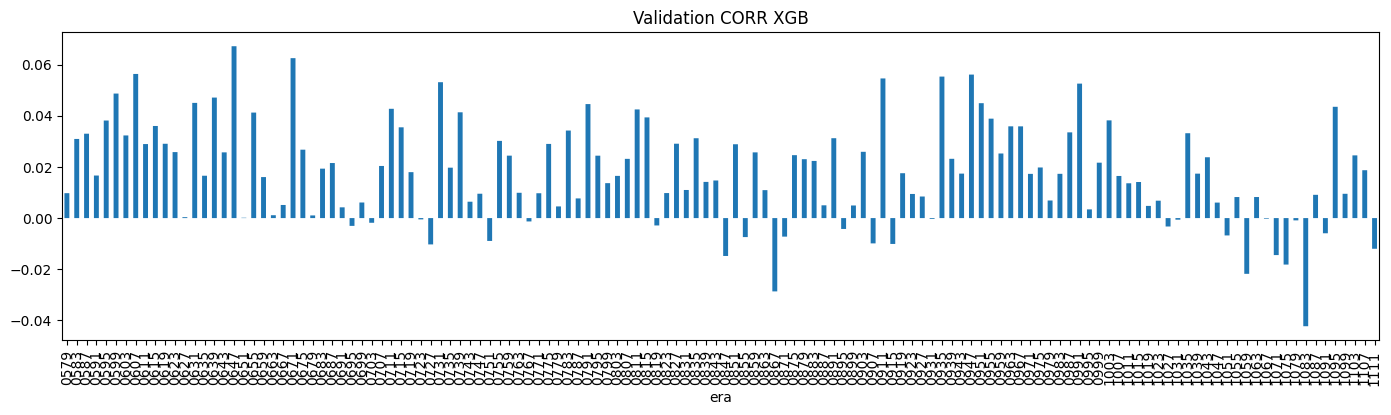

In [66]:
# Compute the per-era corr between our predictions and the target values
per_era_corr_xgb = validation.groupby("era").apply(
    lambda x: numerai_corr(x["prediction_xgb"].dropna(), x["target"].dropna())
)
# Plot the per-era correlation
per_era_corr_xgb.plot(
    title="Validation CORR XGB",
    kind="bar",
    figsize=(17, 4),
    legend=False,
    snap=False
)

<Axes: title={'center': 'Cumulative Validation CORR XGB'}, xlabel='era'>

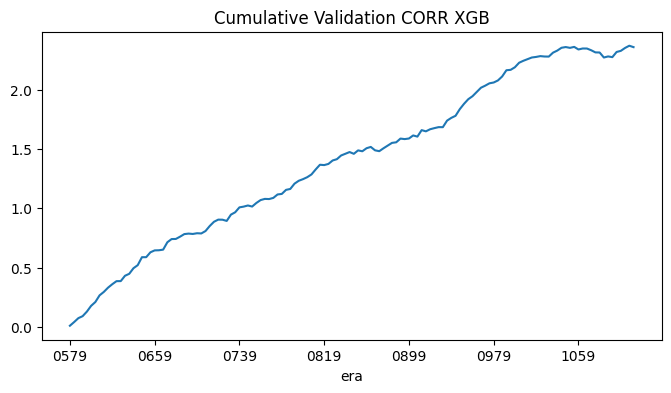

In [60]:
# Plot the cumulative per-era correlation
per_era_corr_xgb.cumsum().plot(
  title="Cumulative Validation CORR XGB",
  kind="line",
  figsize=(8, 4),
  legend=False
)

### Performance metrics

In [61]:
# Compute performance metrics
corr_mean_xgb = per_era_corr_xgb.mean()
corr_std_xgb = per_era_corr_xgb.std(ddof=0)
corr_sharpe_xgb = corr_mean_xgb / corr_std_xgb
corr_max_drawdown_xgb = (per_era_corr_xgb.cumsum().expanding(min_periods=1).max() - per_era_corr_xgb.cumsum()).max()

In [62]:
pd.DataFrame({
    "mean": corr_mean_xgb,
    "std": corr_std_xgb,
    "sharpe": corr_sharpe_xgb,
    "max_drawdown": corr_max_drawdown_xgb
}, index=["CORR XGB"]).T

,CORR XGB
mean,0.017618
std,0.019596
sharpe,0.899073
max_drawdown,0.089677


# Live dataset

In [37]:
# Download latest live features
napi.download_dataset(f"{DATA_VERSION}/live_int8.parquet")

# Load live features
live_features = pd.read_parquet(f"{DATA_VERSION}/live_int8.parquet", columns=feature_set)

2024-05-26 11:27:21,633 INFO numerapi.utils: target file already exists
2024-05-26 11:27:21,634 INFO numerapi.utils: download complete


In [38]:
live_features

,feature_acclimatisable_unfeigned_maghreb,feature_aged_phylacterical_pusey,feature_asinine_unsatiable_avion,feature_bantam_matterful_hut,feature_community_premandibular_fervor,feature_confabulatory_malarian_phenotype,feature_correspondent_orderly_personalisation,feature_deliquescent_pelvic_functionary,feature_detectable_fogbound_dicastery,feature_dormie_sodden_steed,...,feature_undrilled_wheezier_countermand,feature_unfertilized_scaldic_partition,feature_unhorsed_morphogenetic_affusion,feature_unprotested_euphoric_engram,feature_unreproving_capsian_decolourization,feature_unscriptural_coconut_trisulphide,feature_unsuiting_enuretic_milometer,feature_unventilated_sollar_bason,feature_ventriloquistic_relegable_optometer,feature_wistful_tussive_cycloserine
id,,,,,,,,,,,,,,,,,,,,,
n00049e0e1cb37e1,1,4,4,2,1,1,4,1,0,0,...,2,4,0,0,3,3,3,2,1,2
n00236d85dea8b17,0,2,1,4,1,3,0,2,4,0,...,2,3,4,0,1,1,1,1,0,4
n002d31f22ac67a7,0,1,0,0,0,4,0,4,3,0,...,0,0,3,2,1,1,2,0,2,4
n004697c7a96246e,1,1,1,4,3,2,3,3,4,3,...,0,1,3,0,0,0,4,4,1,3
n004ea6ab8458d65,0,0,3,3,2,2,1,2,2,0,...,0,1,2,2,1,3,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
nffcd4572192184e,2,4,3,0,1,0,4,3,1,3,...,1,1,0,0,2,4,3,3,1,3
nffef27dbd3d5b81,0,2,0,4,1,3,4,3,4,0,...,0,1,1,4,1,2,1,0,2,4
nffef8c69fcc0468,0,1,2,0,2,2,1,2,3,0,...,1,4,1,0,0,2,2,2,1,4


In [39]:
# Generate live predictions
live_predictions = model_xgb.predict(live_features[feature_set])

In [40]:
# Format submission
pd.Series(live_predictions, index=live_features.index).to_frame("prediction")

,prediction
id,
n00049e0e1cb37e1,0.490513
n00236d85dea8b17,0.518844
n002d31f22ac67a7,0.492772
n004697c7a96246e,0.505676
n004ea6ab8458d65,0.518585
...,...
nffcd4572192184e,0.498165
nffef27dbd3d5b81,0.506827
nffef8c69fcc0468,0.490707


https://www.kaggle.com/code/carlolepelaars/how-to-get-started-with-numerai 
tu je skóre 0.0499352